# Fraser/Strait of Georgia Freshwater Chemistry Analysis
This is the data notebook
### Sections
   1. [Local Functions](#Local-Functions)
   2. [Load Data](#Load-Data)
   3. [TA regressions](#TA-regressions)
   4. [Fraser River Buoy pH Data](#Fraser-River-Buoy-pH-Data)
   5. [Freshwater DIC:TA scenarios](#Freshwater-DIC:TA-scenarios)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import carbonate
import os
import gsw
import cmocean
from datetime import datetime, timedelta
from scipy import io, signal
from matplotlib import gridspec

%matplotlib inline

## Local Functions

In [3]:
def export_TA_record(TA_record):
    """
    """
    
    # Create new forcing file
    Fraser_file = pd.read_csv(
        '/ocean/bmoorema/research/SOG/SOG-forcing/rivers/Fraser_total_31May2013.dat',
        delim_whitespace=True, names=['year', 'month', 'day', 'flow'],
    )
    Fraser_file = Fraser_file.join(pd.DataFrame(TA_record, columns=['TA']))
    #Fraser.to_csv('/ocean/bmoorema/research/SOG/SOG-forcing/rivers/FraserTA.dat', sep=' ', header=False, index=False)

## Load Data

In [4]:
# Load GRL2016 data
SOG_TA = {}
data = np.loadtxt('/home/bmoorema/Desktop/grl2016.raw')
SOG_TA['crid'] = data[:, 0]
SOG_TA['stn'] = data[:, 3]
SOG_TA['mnth'] = data[:, 4]
SOG_TA['day'] = data[:, 5]
SOG_TA['S'] = data[:, 10]
SOG_TA['alk'] = data[:, 15]
SOG_TA['alk_qf'] = data[:, 16]

In [5]:
# Load Fraser Record
Fraser = {}
data = io.loadmat('/ocean/rich/home/metro/fraser/FRASER.mat')
Fraser['flow'] = data['fraser'][0][0][2].flatten()
Fraser['flow_filter'] = signal.filtfilt(*signal.butter(2, 0.1), Fraser['flow'])
Fraser['dQdt'] = np.diff(Fraser['flow_filter'])/24
Fraser['dQdt'] = np.append(Fraser['dQdt'][0], Fraser['dQdt'])
Fraser['date'] = [
    datetime.fromordinal(int(mtime[0]) - 366) +
    timedelta(days=float(mtime)%1)
    for mtime in data['fraser'][0][0][1]
]

In [7]:
# Load buoy pH record
buoy = {}
data = io.loadmat('/ocean/rich/home/metro/ecbuoy/matlab/ECBUOY.mat')
buoy['date'] = [
    datetime.fromordinal(int(mtime[0])) + timedelta(days=mtime[0]%1) - timedelta(days = 366)
    for mtime in data['ecbuoy'][0][0][4]
]
buoy['T'] = data['ecbuoy'][0][0][5]
buoy['S'] = gsw.conversions.SP_from_C(data['ecbuoy'][0][0][6] * 1e-3, buoy['T'], 0)
buoy['pH'] = carbonate.FindpHOnAllScales(data['ecbuoy'][0][0][16], buoy['T'], buoy['S'], 0, scale='NBS')

In [8]:
# SOG river temp
RiverTemp = 2.5 + (np.arange(365) - 52.8) * (19.3 - 2.5) / (232.9 - 52.8)
RiverTemp[233:] = 19.3 + (np.arange(365)[233:] - 232.9) * (2.5 - 19.3) / (334.4 - 232.9)
RiverTemp[:53] = 2.5
RiverTemp[335:] = 2.5

## TA regressions

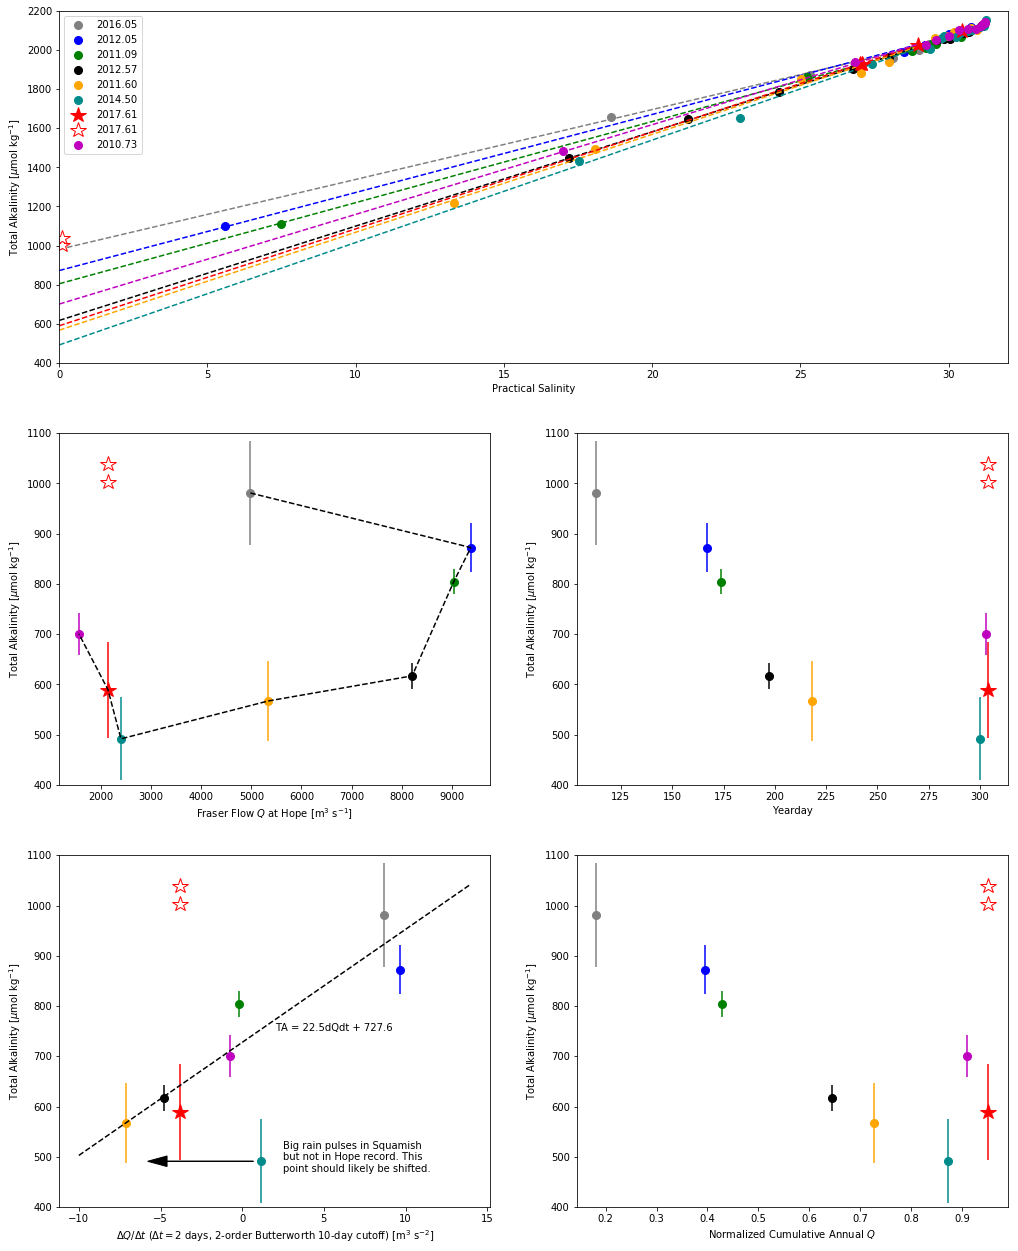

In [9]:
# Cruises to plot
cruises = [2010.73, 2011.09, 2011.60, 2012.05, 2012.57, 2014.50, 2016.05, 2017.61, 2017.61]
stations = [39.5, 42., 39.5, 42., 39.5, 42., 42., 1.5, 0.5]
colors = ['gray', 'b', 'g', 'k', 'orange', 'darkcyan', 'm', 'r', 'r']

cruises = [2016.05, 2012.05, 2011.09, 2012.57, 2011.60, 2014.50, 2017.61, 2017.61, 2010.73]
stations = [42., 42., 42., 39.5, 39.5, 42., 1.5, 0.5, 39.5]
colors = ['gray', 'b', 'g', 'k', 'orange', 'darkcyan', 'r', 'r', 'm']

# Make figure
fig = plt.figure(figsize=(17, 22))
gs = gridspec.GridSpec(3, 2)
axs = [fig.add_subplot(gs[0, :])]
axs.extend([fig.add_subplot(gs[1, col]) for col in range(2)])
axs.extend([fig.add_subplot(gs[2, col]) for col in range(2)])
axs[0].set_xlim([0, 32])
axs[0].set_ylim([400, 2200])
axs[0].set_xlabel('Practical Salinity')
axs[0].set_ylabel('Total Alkalinity [$\mu$mol kg$^{-1}$]')
labels = [
    'Fraser Flow $Q$ at Hope [m$^3$ s$^{-1}$]',
    'Yearday',
    '$\Delta Q/\Delta t$ ($\Delta t = 2$ days, 2-order Butterworth 10-day cutoff) [m$^{3}$ s$^{-2}$]',
    'Normalized Cumulative Annual $Q$',
]
for ax, label in zip(axs[1:], labels):
    ax.set_ylim([400, 1100])
    ax.set_xlabel(label)
    ax.set_ylabel('Total Alkalinity [$\mu$mol kg$^{-1}$]')

x_reg, y_reg = [], []
x_hist, y_hist = [], []

# ------------- Loop through cruises ------------------------
for cruise, station, color in zip(cruises, stations, colors):
    
    # Symbols
    if color is 'r':
        marker = '*'
        size = 16
    else:
        marker = 'o'
        size = 8
    
    # Index
    index = (
        (SOG_TA['crid'] == cruise) &
        (SOG_TA['stn'] == station) &
        ((SOG_TA['alk_qf'] == 2) | (SOG_TA['alk_qf'] == 6))
    )
    
    # Regressions
    if station == 0.5:
        facecolor = 'w'
    else:
        facecolor = color
        S_fit = sm.OLS(SOG_TA['alk'][index], sm.add_constant(SOG_TA['S'][index])).fit()
    
    # Flow metrics
    month, day = int(SOG_TA['mnth'][index][0]), int(SOG_TA['day'][index][0])
    flowindex = [
        abs(np.array(Fraser['date']) - datetime(int(cruise), *yearday)).argmin()
        for yearday in [[month, day], [1, 1], [12, 31]]
    ]
    intQ = Fraser['flow'][flowindex[1]: flowindex[0]].sum()/Fraser['flow'][flowindex[1]: flowindex[2]].sum()
    
    # Salinity Regression Plot
    axs[0].plot(
        SOG_TA['S'][index], SOG_TA['alk'][index],
        marker=marker, color=color,
        markersize=size, markerfacecolor=facecolor,
        linestyle='', label=f'{cruise:.2f}',
    )
    if station != 0.5:
        axs[0].plot(np.arange(30), S_fit.params[1] * np.arange(30) + S_fit.params[0], linestyle='--', color=color)
    
    # Endmember Plots
    metrics = [
        Fraser['flow'][flowindex[0]],
        (Fraser['date'][flowindex[0]] - Fraser['date'][flowindex[1]]).days,
        Fraser['dQdt'][flowindex[0]], intQ,
    ]
    for i, ax, x in zip(range(4), axs[1:], metrics):
        if station == 0.5:
            ax.plot(
                x*np.ones(sum(index)), SOG_TA['alk'][index],
                marker=marker, color=color,
                markerfacecolor=facecolor, markersize=size, linestyle='',
            )
        else:
            ax.plot(x, S_fit.params[0], marker=marker, color=color, markerfacecolor=facecolor, markersize=size)
            ax.errorbar(x, S_fit.params[0], S_fit.conf_int()[0][1] - S_fit.params[0], color=color)
            if i == 2 and cruise != 2014.50:
                x_reg.append(x)
                y_reg.append(S_fit.params[0])
            elif i == 0:
                x_hist.append(x)
                y_hist.append(S_fit.params[0])

axs[1].plot(x_hist, y_hist, 'k--')
dQdt_fit = sm.OLS(np.array(y_reg), sm.add_constant(np.array(x_reg))).fit()
axs[3].plot(np.arange(-10, 15), dQdt_fit.params[1] * np.arange(-10, 15) + dQdt_fit.params[0], 'k--')
axs[3].text(0.5, 0.5, f'TA = {dQdt_fit.params[1]:.1f}dQdt + {dQdt_fit.params[0]:.1f}', transform=axs[3].transAxes)
axs[3].text(0.52, 0.1, 'Big rain pulses in Squamish\nbut not in Hope record. This\npoint should likely be shifted.', transform=axs[3].transAxes)
axs[3].arrow(0.45, 0.13, -0.2, 0, head_width=0.03, fc='k', transform=axs[3].transAxes)
axs[0].legend()
plt.show()

## Fraser River Buoy pH Data

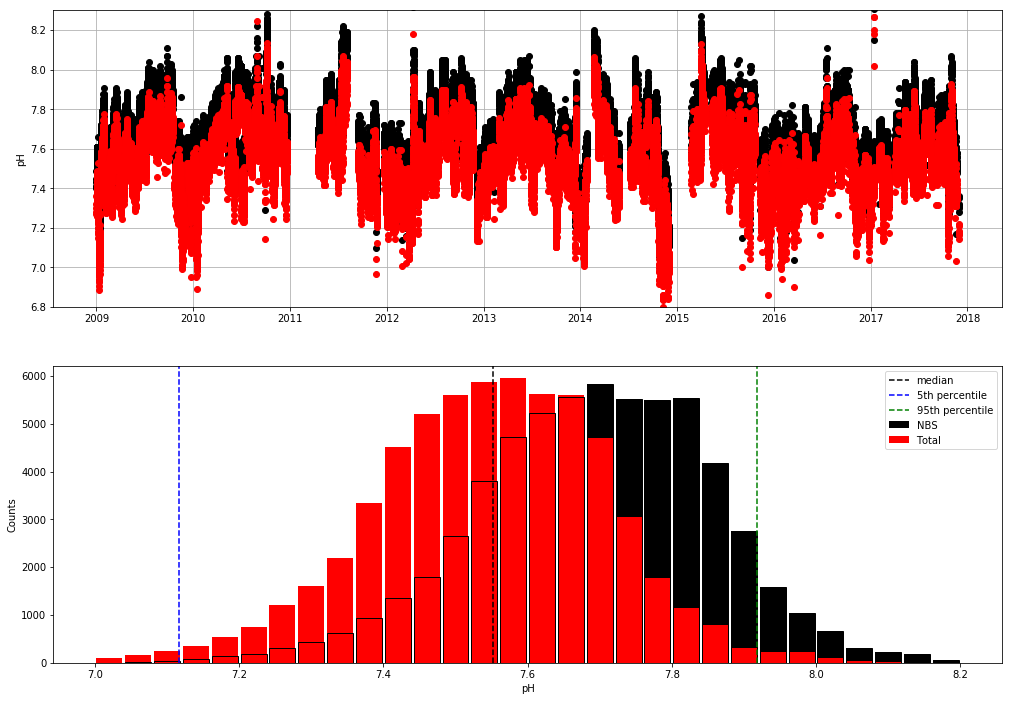

In [10]:
# pH Stats
median = np.nanmedian(buoy['pH']['total'])
percentile_5 = np.nanpercentile(buoy['pH']['total'], 1)
percentile_95 = np.nanpercentile(buoy['pH']['total'], 99)

# Make Figure
fig, ax = plt.subplots(2, 1, figsize=(17, 12))
ax[0].plot(buoy['date'], buoy['pH']['NBS'], 'ko')
ax[0].plot(buoy['date'], buoy['pH']['total'], 'ro')
ax[0].set_ylim([6.8, 8.3])
ax[0].set_ylabel('pH')
ax[0].grid()

ax[1].hist(buoy['pH']['NBS'][~np.isnan(buoy['pH']['NBS'])], bins=30, range=[7, 8.2], rwidth=0.9, color='k', label='NBS')
ax[1].hist(buoy['pH']['total'][~np.isnan(buoy['pH']['total'])], bins=30, range=[7, 8.2], rwidth=0.9, color='r', label='Total')
ax[1].hist(buoy['pH']['NBS'][~np.isnan(buoy['pH']['NBS'])], bins=30, range=[7, 8.2], rwidth=0.9, color='k', fill=False)
ax[1].plot([median, median], [0, 6200], 'k--', label='median')
ax[1].plot([percentile_5, percentile_5], [0, 6200], 'b--', label='5th percentile')
ax[1].plot([percentile_95, percentile_95], [0, 6200], 'g--', label='95th percentile')
ax[1].set_ylim([0, 6200])
ax[1].set_xlabel('pH')
ax[1].set_ylabel('Counts')
ax[1].legend()
plt.show()

## Freshwater DIC:TA scenarios
Plot model freshwater DIC:TA as determined by TA and pH

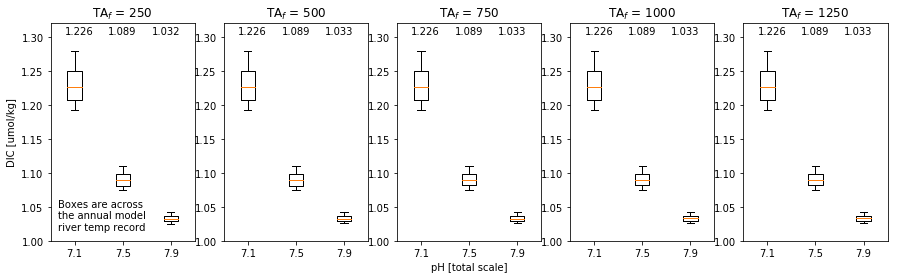

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))
axs[0].set_ylabel('DIC [umol/kg]')
axs[2].set_xlabel('pH [total scale]')
axs[0].text(0.05, 0.05, 'Boxes are across\nthe annual model\nriver temp record', transform=axs[0].transAxes)
pHs = [7.1, 7.5, 7.9]
TAs = [250, 500, 750, 1000, 1250]
lims = [
    [150, 405],
    [400, 755],
    [700, 1055],
    [975, 1330],
    [1275, 1630],
]
for ax, lim, TA in zip(axs, lims, TAs):
    CO2 = []
    for pH, pos in zip(pHs, [0.1, 0.4, 0.7]):
        data = carbonate.calc_carbonate([TA, pH], 0, 0, np.arange(2.5, 19.4, 0.1), 0, 0, params=['TA', 'pH'])
        CO2.append(data['TC']/TA)
        ax.text(pos, 0.95, f'{np.nanmedian(data["TC"]/TA):.3f}', transform=ax.transAxes)
    ax.boxplot(CO2, labels=pHs)
    ax.set_ylim([1, 1.32])
    ax.set_title(f'TA$_f$ = {TA}')
plt.show()